In [1]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np
from utils import create_model
from CONFIG import CONFIG
import numpy as np

from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from matplotlib import cm

/home/lorenzoquerol/miniconda3/envs/wssv-recognition/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
TEST_DIR = "dataset/augmented-segmented/test"
CLASS_NAMES = ["healthy", "wssv"]

test_dataset = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    seed=CONFIG["seed_value"],
    image_size=CONFIG["img_shape"],
    batch_size=CONFIG["batch_size"],
    label_mode="categorical",
).prefetch(buffer_size=tf.data.AUTOTUNE)

test_images = []
test_labels = []
for X, y in test_dataset.as_numpy_iterator():
    test_images.append(X)
    test_labels.append(y)

test_images = np.concatenate(test_images)
test_labels = np.argmax(np.concatenate(test_labels), axis=1)

replace2linear = ReplaceToLinear()
X = np.asarray(test_images)
test_labels = list(test_labels)
score = CategoricalScore(test_labels)

Found 13 files belonging to 2 classes.


# EfficientNetV2B0 Saliency


In [3]:
"""
EFFICIENTNETV2B0
"""
EFFICIENTNET_CHECKPOINTS = "checkpoints/efficientnetv2b0-segmented"
EFFICIENTNET_LATEST = tf.train.latest_checkpoint(EFFICIENTNET_CHECKPOINTS)

EFFICIENTNET_MODEL = tf.keras.applications.EfficientNetV2B0(
    input_shape=CONFIG["input_shape"],
    include_top=False,
    classes=CONFIG["num_classes"],
)

EFFICIENTNET_MODEL = create_model(EFFICIENTNET_MODEL, CONFIG)
EFFICIENTNET_MODEL.load_weights(EFFICIENTNET_LATEST).expect_partial()


def efficient_modifier(model):
    EFFICIENTNET_MODEL.layers[-1].activation = tf.keras.activations.linear


EFFICIENTNET_GRADCAM = GradcamPlusPlus(
    EFFICIENTNET_MODEL.get_layer("efficientnetv2-b0"),
    model_modifier=efficient_modifier,
    clone=True,
)
EFFICIENTNET_CAM = EFFICIENTNET_GRADCAM(score, X, penultimate_layer=-1)

In [4]:
"""
MOBILENETV3
"""
MOBILENET_CHECKPOINTS = "checkpoints/mobilenetv3small-segmented"
MOBILENET_LATEST = tf.train.latest_checkpoint(MOBILENET_CHECKPOINTS)
MOBILENET_MODEL = tf.keras.applications.MobileNetV3Small(
    input_shape=CONFIG["input_shape"],
    include_top=False,
    classes=CONFIG["num_classes"],
)

MOBILENET_MODEL = create_model(MOBILENET_MODEL, CONFIG)
MOBILENET_MODEL.load_weights(MOBILENET_LATEST).expect_partial()

MOBILENET_GRADCAM = GradcamPlusPlus(
    MOBILENET_MODEL.get_layer("MobilenetV3small"),
    model_modifier=replace2linear,
    clone=True,
)
MOBILENET_CAM = MOBILENET_GRADCAM(score, X, penultimate_layer=-1)

1/1 [==============================] - 1s 951ms/step


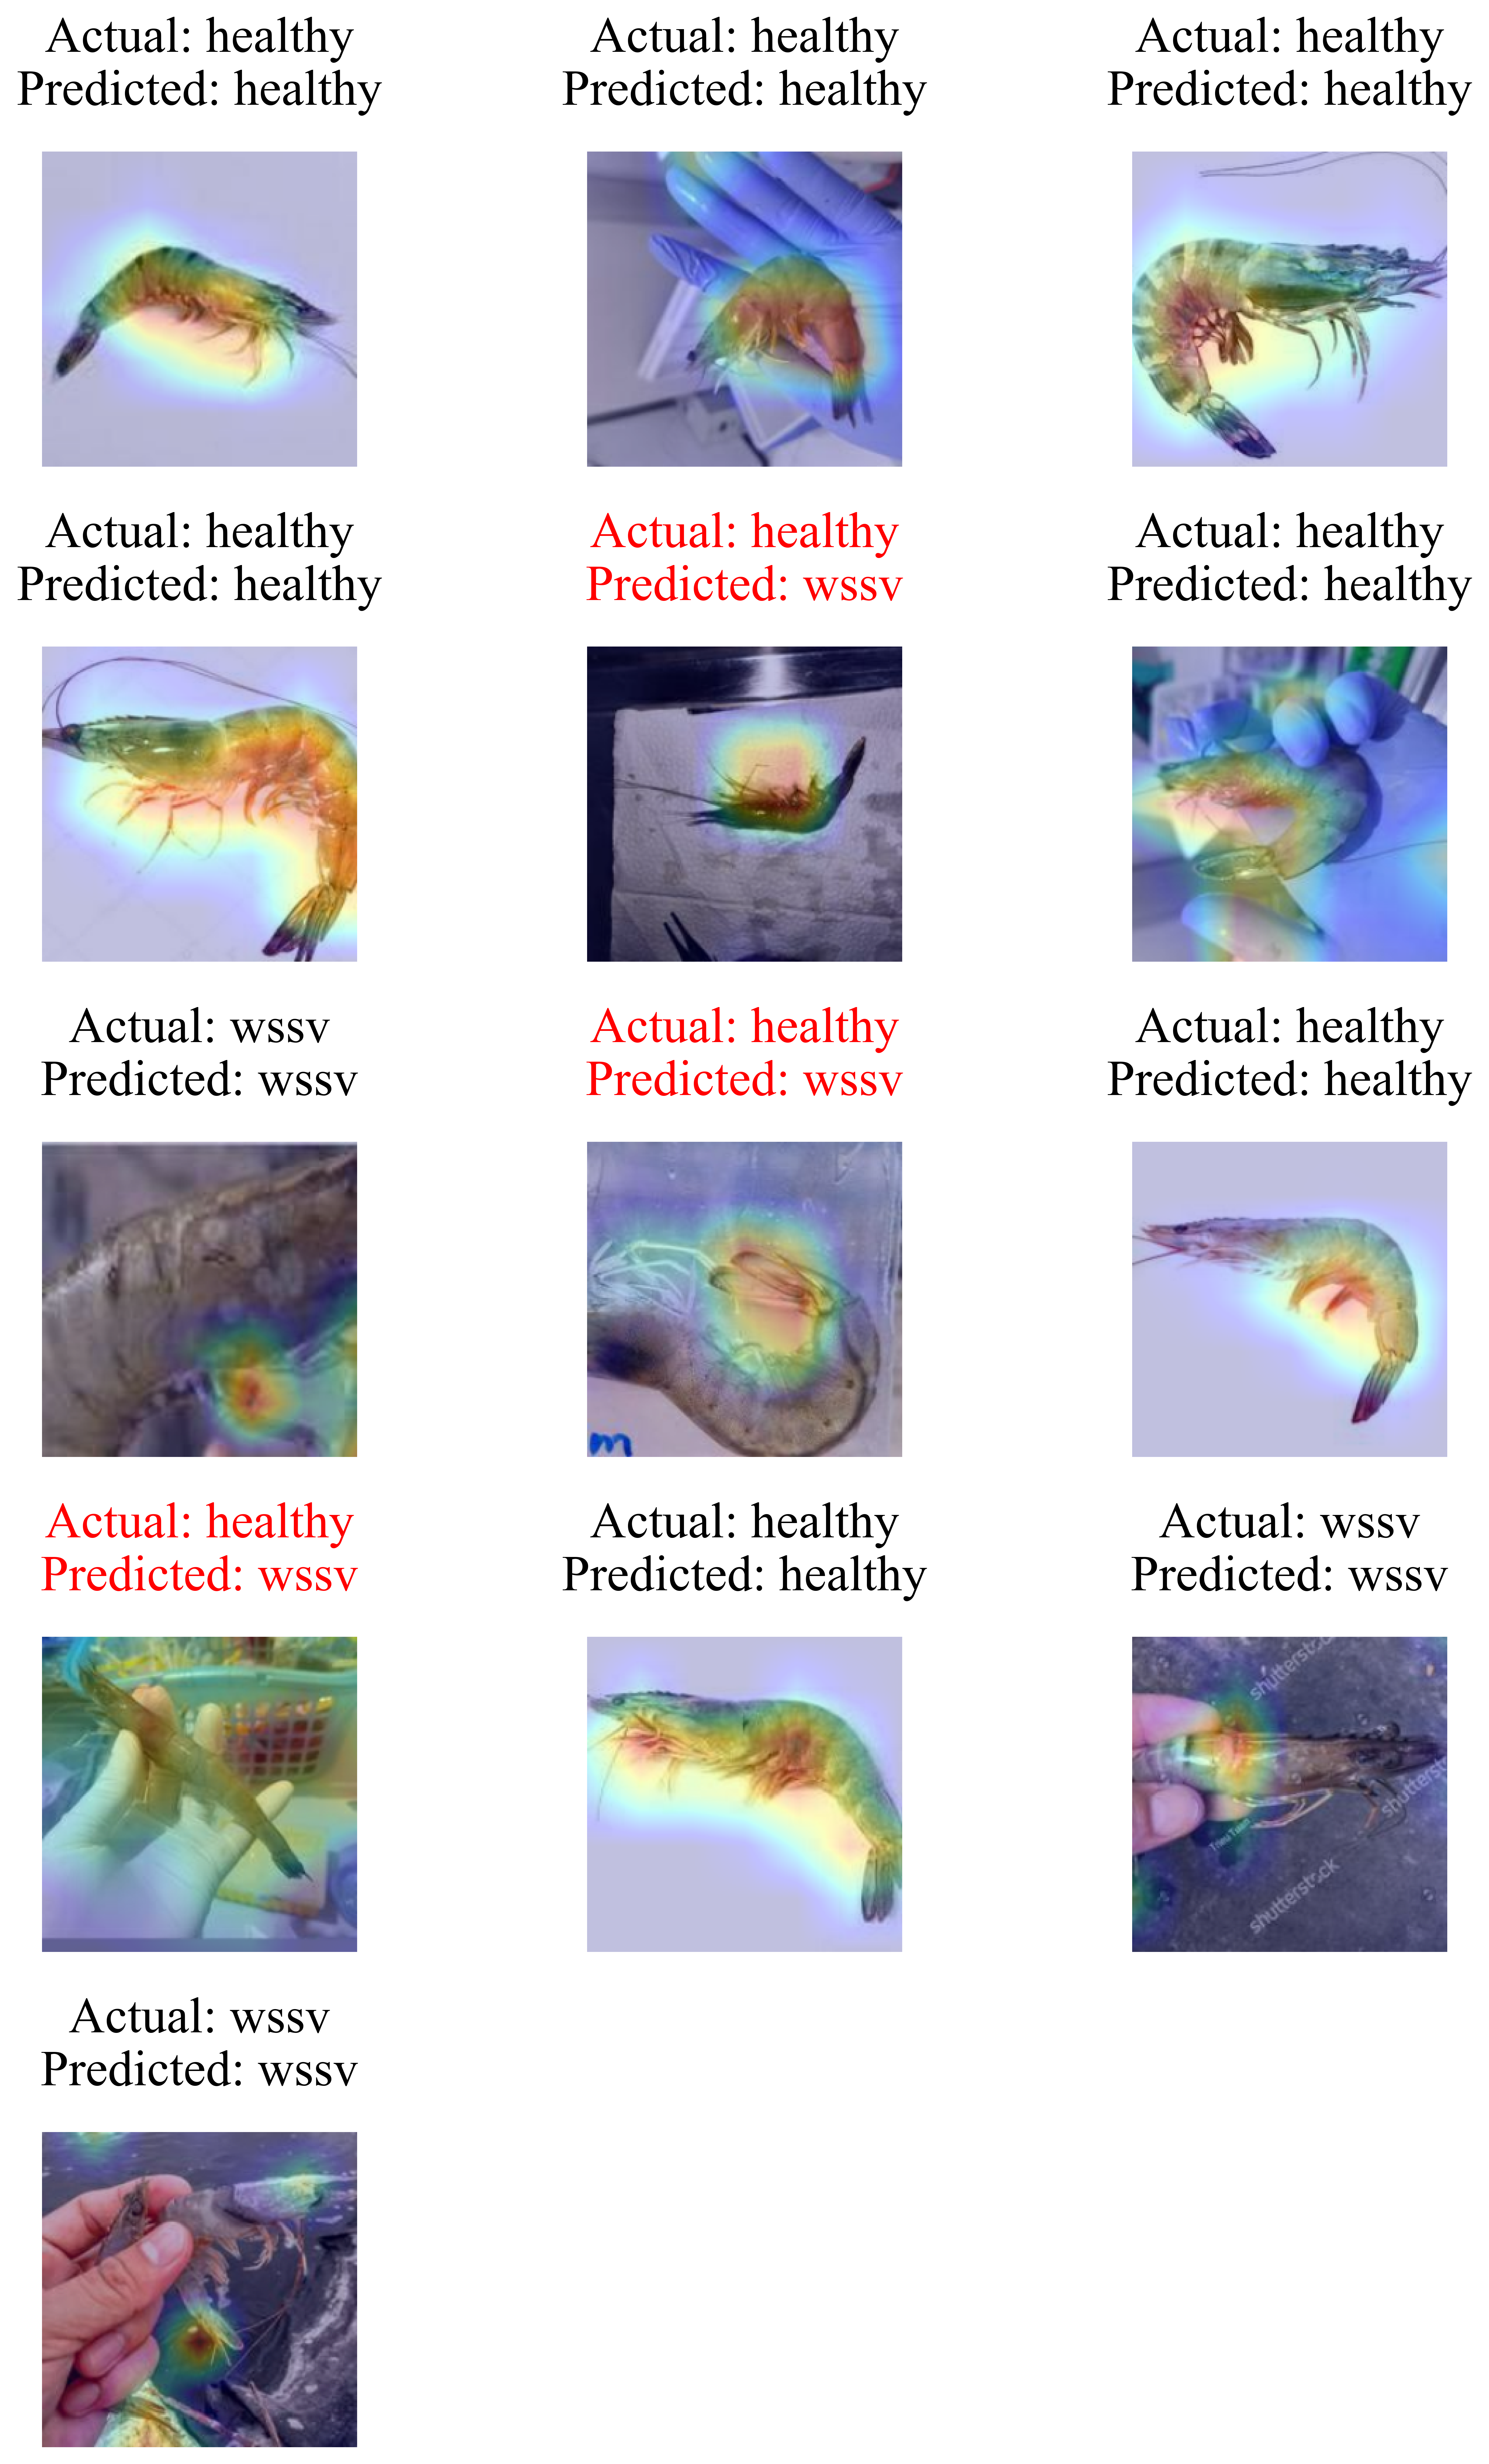

In [5]:
# change font to times new roman
plt.rcParams["font.family"] = "Times New Roman"
# change font size
plt.rcParams.update({"font.size": 18})
# add padding to title
plt.rcParams["axes.titlepad"] = 20


predictions = EFFICIENTNET_MODEL.predict(test_images).argmax(axis=1)

plt.figure(figsize=(10, 15), dpi=600)
for i, title in enumerate(test_labels):
    ax = plt.subplot(5, 3, i + 1)
    heatmap = np.uint8(cm.jet(EFFICIENTNET_CAM[i])[..., :3] * 255)
    label = CLASS_NAMES[title]

    if CLASS_NAMES[test_labels[i]] is not CLASS_NAMES[predictions[i]]:
        misclassified = True
    else:
        misclassified = False

    plt.title(
        f"Actual: {CLASS_NAMES[test_labels[i]]}\nPredicted: {CLASS_NAMES[predictions[i]]}",
        color="red" if misclassified else "black",
    )

    plt.imshow(test_images[i] / 255)
    plt.imshow(heatmap, cmap="jet", alpha=0.25)  # overlay
    plt.axis("off")

plt.tight_layout()
plt.show()

1/1 [==============================] - 1s 577ms/step


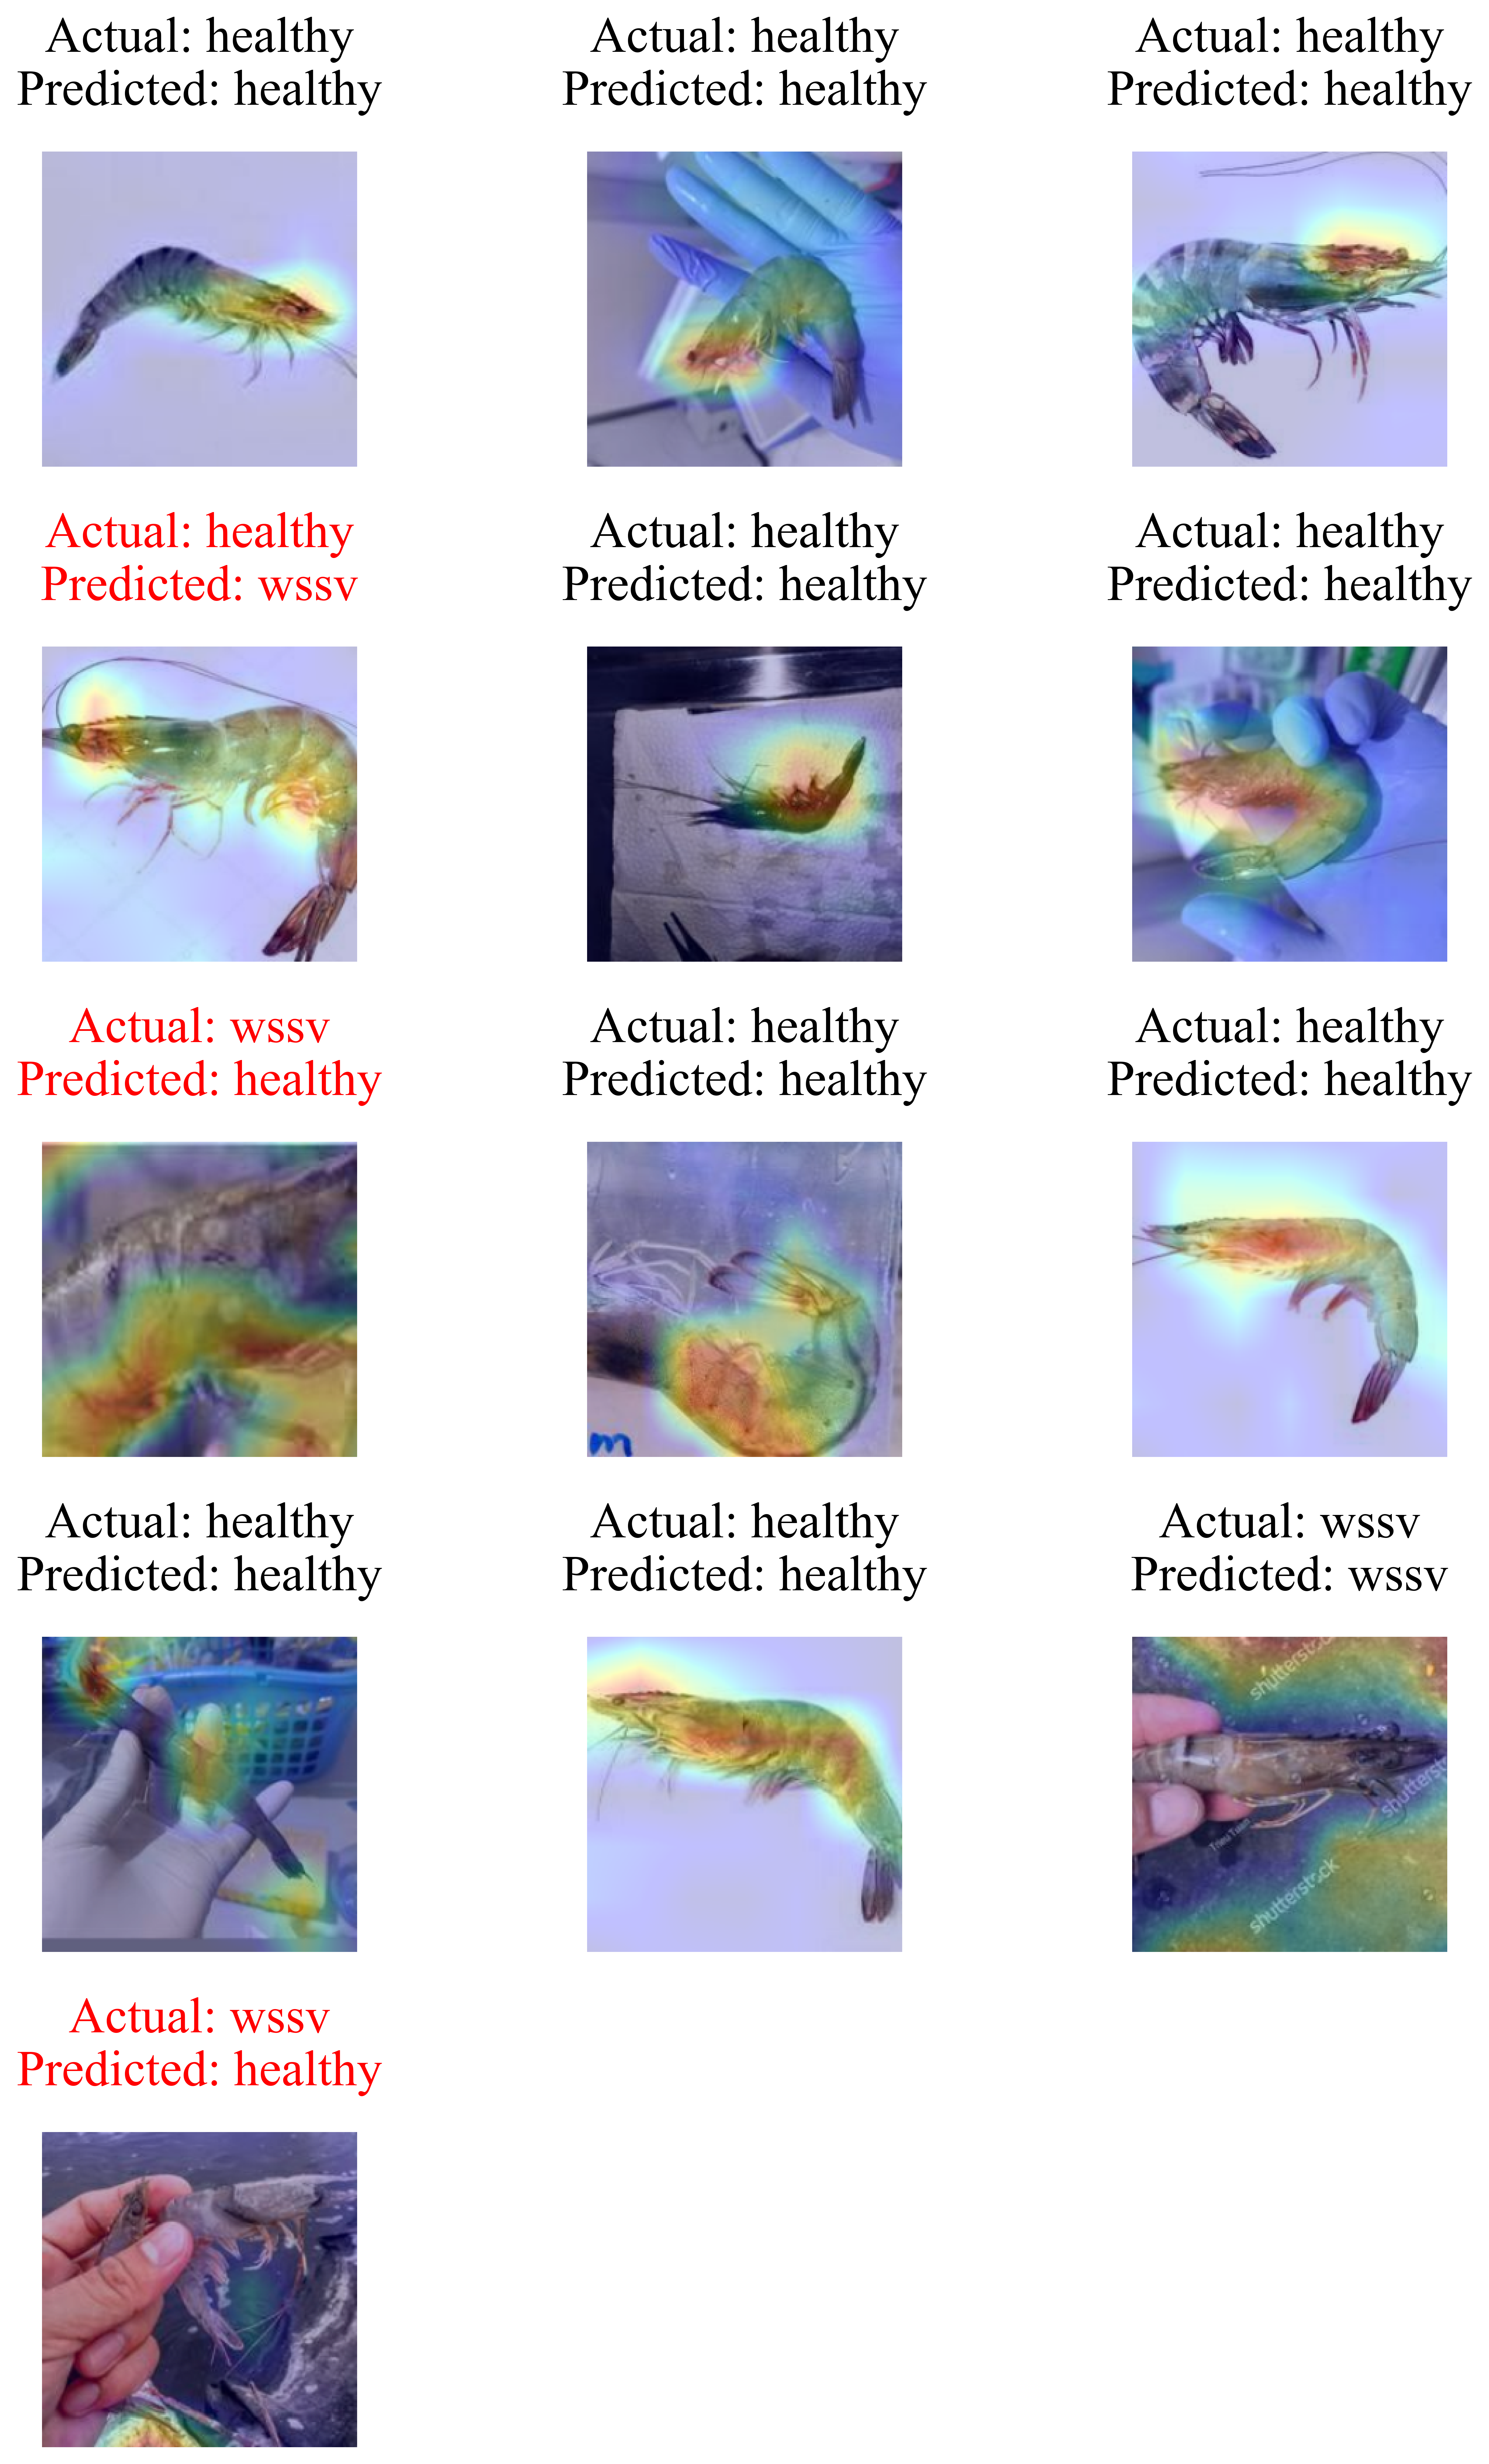

In [6]:
predictions = MOBILENET_MODEL.predict(test_images).argmax(axis=1)

plt.figure(figsize=(10, 15), dpi=600)
for i, title in enumerate(test_labels):
    ax = plt.subplot(5, 3, i + 1)
    heatmap = np.uint8(cm.jet(MOBILENET_CAM[i])[..., :3] * 255)
    label = CLASS_NAMES[title]

    if CLASS_NAMES[test_labels[i]] is not CLASS_NAMES[predictions[i]]:
        misclassified = True
    else:
        misclassified = False

    plt.title(
        f"Actual: {CLASS_NAMES[test_labels[i]]}\nPredicted: {CLASS_NAMES[predictions[i]]}",
        color="red" if misclassified else "black",
    )

    plt.imshow(test_images[i] / 255)
    plt.imshow(heatmap, cmap="jet", alpha=0.25)  # overlay
    plt.axis("off")

plt.tight_layout()
plt.show()